# Рекомендательные системы на основе SVD и KNN

Ниже рассмотрим несколько алгоритмов для рекомендательных систем, где метрикой качества будет RMSE, а задачей выступит датасет MovieLens

In [1]:
from surprise import Dataset
from surprise import Reader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold

from knn_inherited import KNNMeans, KNNBasic

from sklearn.model_selection import train_test_split

from svd import SVD

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OrdinalEncoder

import warnings

warnings.filterwarnings("ignore")


seed = 0xAB0BA
np.random.seed(seed)

In [2]:
data = Dataset.load_builtin("ml-100k")

In [3]:
df = pd.DataFrame(data.raw_ratings)
df.columns = ["user", "item", "rating", "timestamp"]
df.head()

,user,item,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


# эксперименты KNN по числу соседей

In [ ]:
kf = KFold(5)

k_ls = [1, 3, 5, 7, 10, 15, 20, 25]

res_time = []
res_rmse = []

res_time_m = []
res_rmse_m = []


for k in tqdm(k_ls):
    time_ls = []
    rmse_ls = []
    time_ls_m = []
    rmse_ls_m = []
    for train_index, test_index in kf.split(df):
        X_train, X_test = df.loc[train_index], df.loc[test_index]

        rating_matrix = X_train.pivot(
            index="item", columns="user", values="rating"
        ).fillna(0)

        start = time.time()
        knn = KNNBasic(k)
        knn.fit(rating_matrix)
        y_pred, y_test = knn.predict(X_test)
        end = time.time()

        time_ls.append(end - start)
        rmse_ls.append(mean_squared_error(y_test, y_pred, squared=False))

        start = time.time()
        knn = KNNMeans(k)
        knn.fit(rating_matrix)
        y_pred, y_test = knn.predict(X_test)
        end = time.time()

        time_ls_m.append(end - start)
        rmse_ls_m.append(mean_squared_error(y_test, y_pred, squared=False))

    res_time.append(np.mean(time_ls))
    res_rmse.append(np.mean(rmse_ls))

    res_time_m.append(np.mean(time_ls_m))
    res_rmse_m.append(np.mean(rmse_ls_m))

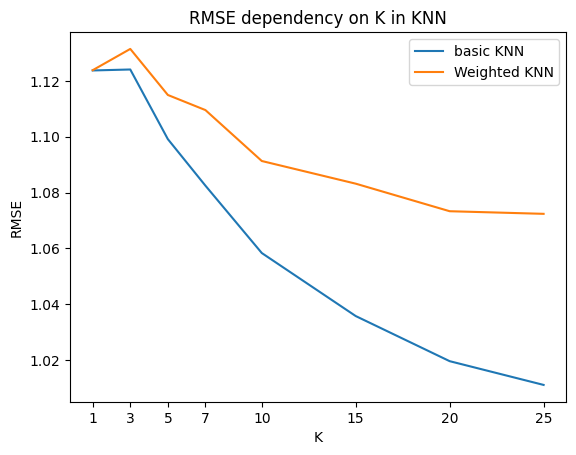

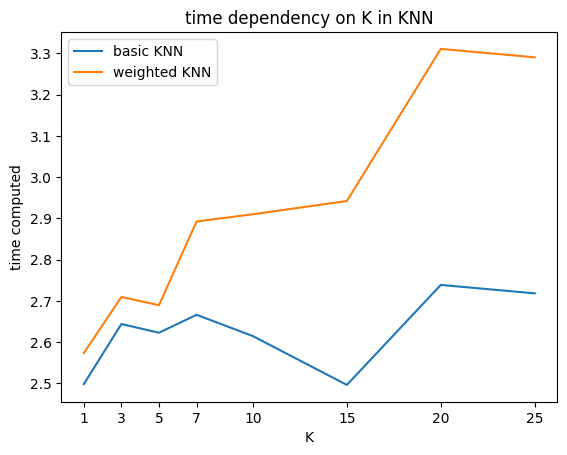

In [ ]:
plt.plot(k_ls, res_rmse, label="basic KNN")
plt.plot(k_ls, res_rmse_m, label="Weighted KNN")
plt.xticks(k_ls)
plt.xlabel("K")
plt.ylabel("RMSE")
plt.title("RMSE dependency on K in KNN")
plt.legend()
plt.show()

plt.plot(k_ls, res_time, label="basic KNN")
plt.plot(k_ls, res_time_m, label="weighted KNN")
plt.xticks(k_ls)
plt.xlabel("K")
plt.ylabel("time computed")
plt.title("time dependency on K in KNN")
plt.legend()
plt.show()

Видно, что в целом с увеличением числа соседей растет и время вычисления, что абсолютно логично. Какой то странный выброс на 15 соседях в обычном кнне, возможно что-то системное, потому что считалось в коллабе. Ожидаемо взвешенный кнн работает дольше. На взвешенном кнне необходимо выполнять дополнительные вычисления, видимо из за них и получается так долго.


В плане RMSE видно, что чм больше берем соседей тем лучше оценка, что тоже является логичным. Странно что взвешенный кнн здесь проигрывает обычному, видимо на нашем небольшом и разреженном датасете понятие близости и более сильного его влияния не всегда оправдывает себя и полностью описывает природу человеческих предпочтений. Я предполагаю, что если оценки с другим юзером могут быть похожи по некоторым фильмам, то по другим будут непохожи и это нормально кажется в реальной жизни. 

# Эксперименты SVD

In [ ]:
kf = KFold(3)

n_factors = [2, 3, 5, 7, 9, 15, 30]


res_time = []
res_rmse = []

res_time_pp = []
res_rmse_pp = []

res_time_als = []
res_rmse_als = []


for nf in tqdm(n_factors):
    time_ls = []
    rmse_ls = []
    time_ls_pp = []
    rmse_ls_pp = []
    time_ls_als = []
    rmse_ls_als = []

    for train_index, test_index in kf.split(df):
        X_train, X_test = df.loc[train_index], df.loc[test_index]

        svd = SVD(nf)
        start = time.time()
        svd.fit(X_train, algo="sgd", verbose=None)
        y_pred, y_test = svd.predict(X_test)
        end = time.time()

        time_ls.append(end - start)
        rmse_ls.append(mean_squared_error(y_test, y_pred, squared=False))

        start = time.time()
        svd.fit(X_train, algo="svd++", verbose=None)
        y_pred, y_test = svd.predict(X_test)
        end = time.time()

        time_ls_pp.append(end - start)
        rmse_ls_pp.append(mean_squared_error(y_test, y_pred, squared=False))

        start = time.time()
        svd.fit(X_train, algo="als", verbose=None, n_epoch=3)
        y_pred, y_test = svd.predict(X_test)
        end = time.time()

        time_ls_als.append(end - start)
        rmse_ls_als.append(mean_squared_error(y_test, y_pred, squared=False))

    res_time.append(np.mean(time_ls))
    res_rmse.append(np.mean(rmse_ls))

    res_time_pp.append(np.mean(time_ls_pp))
    res_rmse_pp.append(np.mean(rmse_ls_pp))

    res_time_als.append(np.mean(time_ls_als))
    res_rmse_als.append(np.mean(rmse_ls_als))

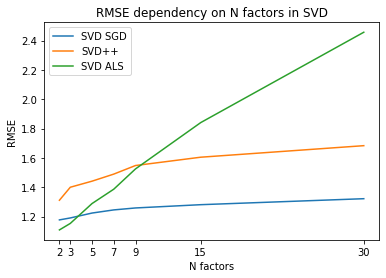

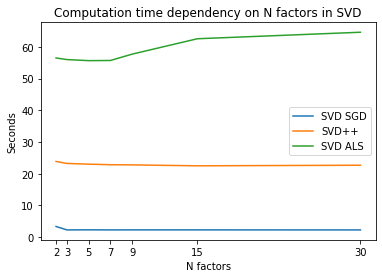

In [6]:
plt.plot(n_factors, res_rmse, label="SVD SGD")
plt.plot(n_factors, res_rmse_pp, label="SVD++")
plt.plot(n_factors, res_rmse_als, label="SVD ALS")
plt.xticks(n_factors)
plt.xlabel("N factors")
plt.ylabel("RMSE")
plt.title("RMSE dependency on N factors in SVD")
plt.legend()
plt.show()

plt.plot(n_factors, res_time, label="SVD SGD")
plt.plot(n_factors, res_time_pp, label="SVD++")
plt.plot(n_factors, res_time_als, label="SVD ALS")
plt.xticks(n_factors)
plt.xlabel("N factors")
plt.ylabel("Seconds")
plt.title("Computation time dependency on N factors in SVD")
plt.legend()
plt.show()

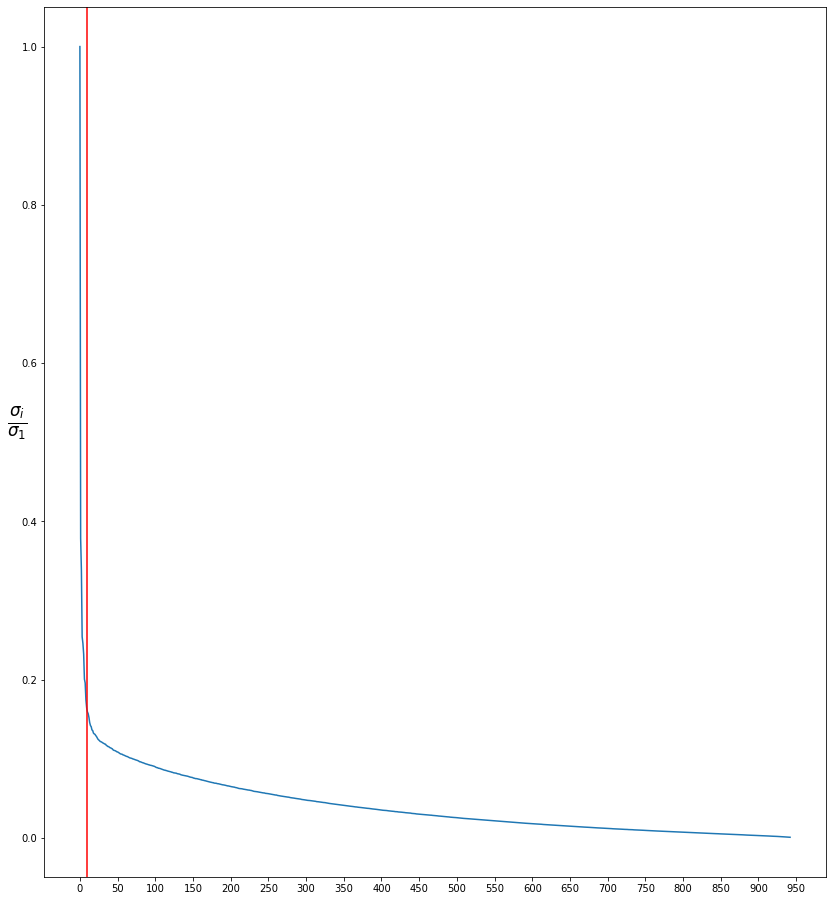

In [55]:
U, S, Vt = np.linalg.svd(
    (X_train.pivot(index="item", columns="user", values="rating").fillna(0)).to_numpy()
)

plt.figure(figsize=(14, 16))
plt.plot(S / S[0])
plt.axvline(x=10, color="r")
plt.xticks(np.arange(0, 1000, 50))
plt.ylabel(r"$\frac{\sigma_i}{\sigma_1}$", fontsize=24, rotation=0)
plt.show()

Время вычислений примерно одинаковое, так как количество факторов добавляет только матричных операций. В АЛС методе видим такой скачек, так как видимо обращать матрицу большей размерности стало действительно сложнее и дольше, может быть даже нампай перешел к другому алгоритму вычисления обратной (просто предполагаю).

По RMSE видно, что увеличение количества факторов нам только все портит с фиксированным количеством эпох и итераций. Есть несколько гипотез почему так могло произойти. Первая - то, что мы просто их недоучили и им не хватило итераций чтобы сойтись. Думаю, что с ALS дело именно в этом, пока я его писал было видно, что нужно несколько эпох чтобы сойтись. Но это прям долго, потому что некоторые вещи в ALS не перекладываются на язык матричных операций в нампае, а писать на Cythone это уже оверкилл кажется)


Вторая - большое количество факторов на небольшом датасете это слишком. В подтверждение мы можем выше пронаблюдать график сингулярных чисел в СВД. Видно, что после 10го они выходят совсем на плато, по сравнению с наибольшим.

# Сравнение СВД по числу итераций

In [ ]:
n_iters = [5, 10, 50, 100, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000, 40000]


res_rmse = []
res_rmse_pp = []


for ni in tqdm(n_iters):
    rmse_ls = []
    rmse_ls_pp = []

    for train_index, test_index in kf.split(df):
        X_train, X_test = df.loc[train_index], df.loc[test_index]

        svd = SVD()
        svd.fit(X_train, algo="sgd", verbose=None, n_iters=ni)
        y_pred, y_test = svd.predict(X_test)

        rmse_ls.append(mean_squared_error(y_test, y_pred, squared=False))

        svd.fit(X_train, algo="svd++", verbose=None, n_iters=ni)
        y_pred, y_test = svd.predict(X_test)

        rmse_ls_pp.append(mean_squared_error(y_test, y_pred, squared=False))

    res_rmse.append(np.mean(rmse_ls))

    res_rmse_pp.append(np.mean(rmse_ls_pp))

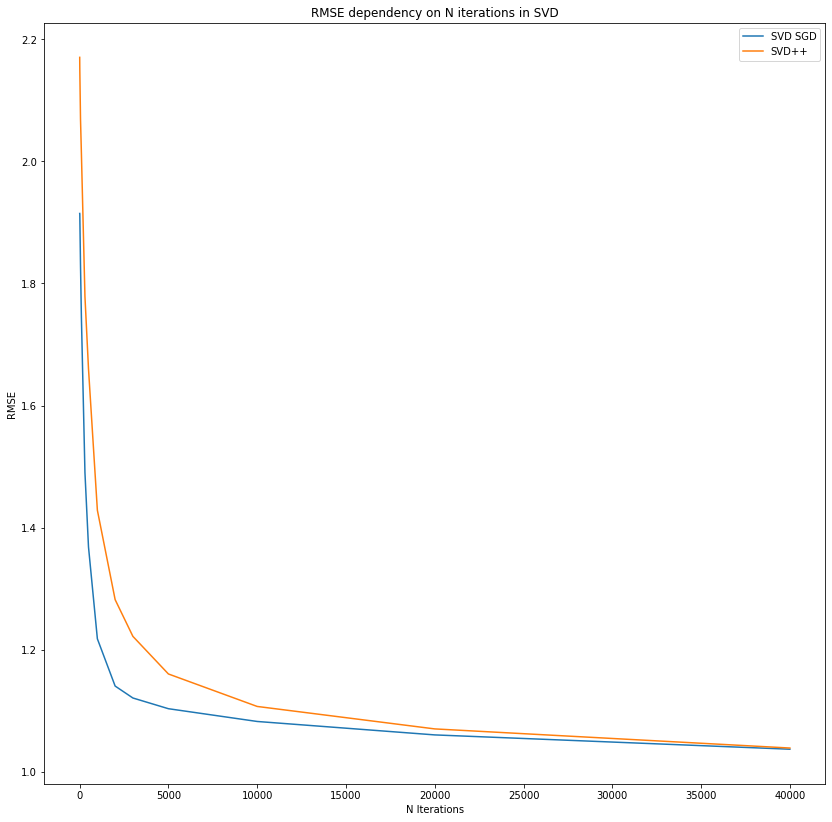

In [19]:
plt.figure(figsize=(14, 14))
plt.plot(n_iters, res_rmse, label="SVD SGD")
plt.plot(n_iters, res_rmse_pp, label="SVD++")
# plt.xticks(n_iters, rotation = 90)
plt.xlabel("N Iterations")
plt.ylabel("RMSE")
plt.title("RMSE dependency on N iterations in SVD")
plt.legend()
plt.show()

Видим, что с увеличением итераций качество растет, но в итоге выходит на плато. СВД++ требует очевидно больше итераций, так как в нем больше параметров для оптимизации. 

In [ ]:
kf = KFold(5)

knn_basic = KNNBasic(25)
knn_means = KNNMeans(25)

svd_pp = SVD()
svd_sgd = SVD()
svd_als = SVD()


rmse_kn = []
rmse_km = []
rmse_svd_pp = []
rmse_svd_als = []
rmse_svd_sgd = []

time_kn = []
time_km = []
time_svd_pp = []
time_svd_als = []
time_svd_sgd = []

for train_index, test_index in tqdm(kf.split(df)):
    X_train, X_test = df.loc[train_index], df.loc[test_index]

    rating_matrix = X_train.pivot(index="item", columns="user", values="rating").fillna(
        0
    )

    start = time.time()
    knn_basic.fit(rating_matrix)
    y_pred, y_test = knn_basic.predict(X_test)
    end = time.time()

    rmse_kn.append(mean_squared_error(y_test, y_pred, squared=False))
    time_kn.append(end - start)

    start = time.time()
    knn_means.fit(rating_matrix)
    y_pred, y_test = knn_means.predict(X_test)
    end = time.time()

    rmse_km.append(mean_squared_error(y_test, y_pred, squared=False))
    time_km.append(end - start)

    start = time.time()
    svd_sgd.fit(X_train, algo="sgd", verbose=None)
    y_pred, y_test = svd_sgd.predict(X_test)
    end = time.time()

    time_svd_sgd.append(end - start)
    rmse_svd_sgd.append(mean_squared_error(y_test, y_pred, squared=False))

    start = time.time()
    svd_pp.fit(X_train, algo="svd++", verbose=None)
    y_pred, y_test = svd_pp.predict(X_test)
    end = time.time()

    time_svd_pp.append(end - start)
    rmse_svd_pp.append(mean_squared_error(y_test, y_pred, squared=False))

    start = time.time()
    svd_als.fit(X_train, algo="als", verbose=None, n_epoch=3)
    y_pred, y_test = svd_als.predict(X_test)
    end = time.time()

    time_svd_als.append(end - start)
    rmse_svd_als.append(mean_squared_error(y_test, y_pred, squared=False))

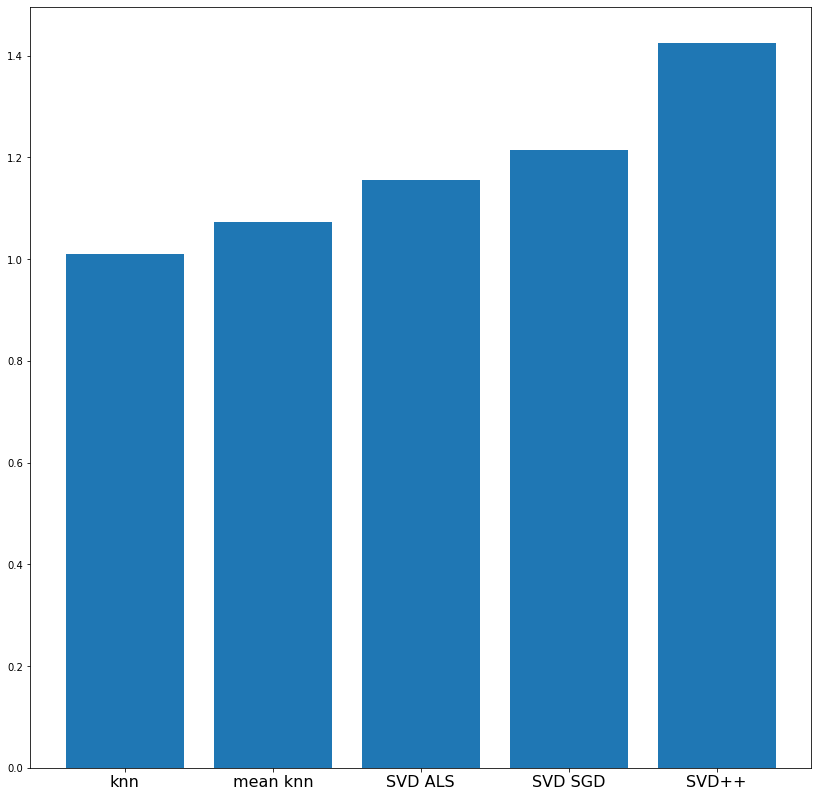

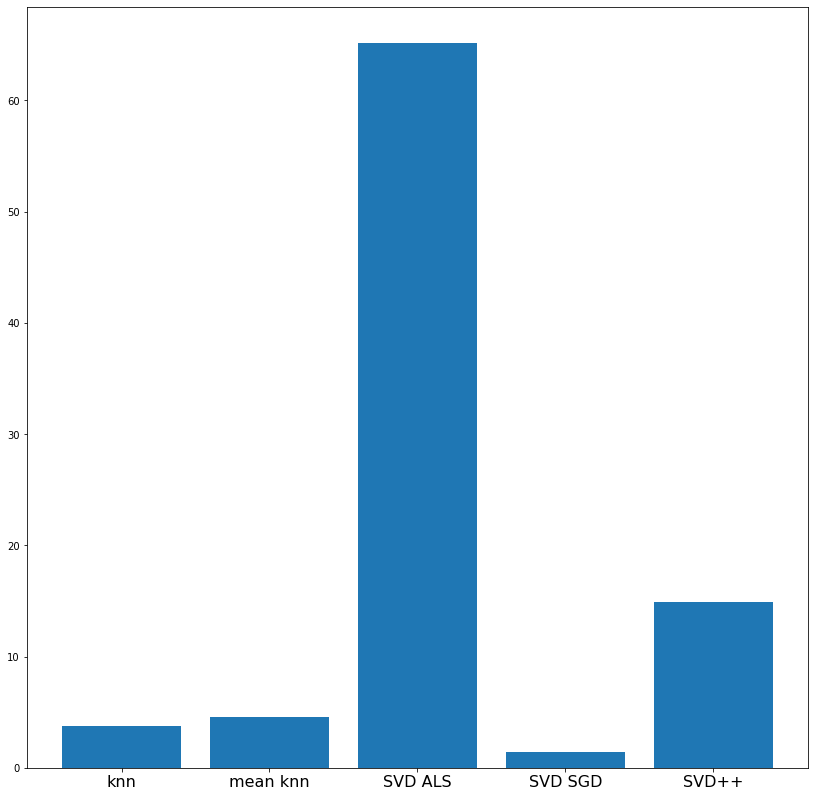

In [45]:
mean_res = [
    np.mean(rmse_kn),
    np.mean(rmse_km),
    np.mean(rmse_svd_als),
    np.mean(rmse_svd_sgd),
    np.mean(rmse_svd_pp),
]
mean_time = [
    np.mean(time_kn),
    np.mean(time_km),
    np.mean(time_svd_als),
    np.mean(time_svd_sgd),
    np.mean(time_svd_pp),
]
names = ["knn", "mean knn", "SVD ALS", "SVD SGD", "SVD++"]

plt.figure(figsize=(14, 14))
plt.bar(np.arange(5), mean_res)
plt.xticks(np.arange(5), labels=names, fontsize=16)
plt.show()

plt.figure(figsize=(14, 14))
plt.bar(np.arange(5), mean_time)
plt.xticks(np.arange(5), labels=names, fontsize=16)
plt.show()

Среди всех алгоритмов самые крутые - это кнны) я думаю, что это связано с количеством итераций и количеством данных, кажется что у нас небольшой датасет.

По времени SVD ALS понятно, обсуждалось выше, SGD сходится быстро, так как там по умолчанию 1000 итераций, которые уже приводят к хорошему результату. в SVD++ в предикте и в трейне приходится каждый раз индексировать матрицу с неявной имплицитной информации о взаимодействии пользователя.

